In [22]:
#Goal - Refactor and Improve the Gensim Word2Vec LSI NLP model using Scikit-learn, adhering to the CRISP-DM Process

#LDA Overview: LDA is technique in natural language processing of analyzing relationships between a set of documents 
#and the terms they contain by producing a set of concepts related to the documents and terms. 
#i.e. LDA assumes that words that are close in meaning will occur in similar pieces of text 

#global variable that work as model parameters - adjust for model performance "fine-tuning"
n_samples = 2000 #sample size
n_features = 1000 #name/entity recgonition & group selection (vectors)
n_components = 5 #themes
n_top_words = 10 #words per theme

In [23]:
#import libraries for data structures and Gensim Word2Vec API
import os
import tempfile
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
import numpy as np
import pandas as pd
import gensim #open-source achine learning framework
from gensim import corpora
from gensim import models
#data pre-processing tools from gensim package
from gensim.parsing.preprocessing import strip_non_alphanum 
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_short
#import scikit-learn & graphical libraries
# Any results you write to the current directory are saved as output.
from sklearn import preprocessing #data prep - module includes scaling, centering, normalization, binarization and imputation methods.
from sklearn.feature_extraction import text #used for removing stop words and obtaining feature extraction from text
import matplotlib.pyplot as plt
import seaborn as sns #Seaborn is a Python data visualization library based on matplotlib. 
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

#import sklearn libraries for NLP prep, model bilding & validation steps - for use in Dataiku
from sklearn.metrics import accuracy_score  #used for model evaluation - https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
from sklearn.feature_extraction.text import CountVectorizer  #bag-of-words vectorication for LDA model
from sklearn.decomposition import LatentDirichletAllocation #model for NLP topic extraction, similar to gensim LDA
from sklearn.datasets import make_multilabel_classification #create random test dataset
from sklearn.model_selection import train_test_split

Folder "C:\Users\JTBVEN~1\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [24]:
#CRISP-DM Task: Data Preparation 
#import favorite text-based dataset for analysis using pandas dataframe - compatible w/scikit-learn
def read_text(path):
    print("Pandas File I/O Example - csv read")
    text=pd.read_csv(path) #import to pandas DataFrame
    return text #return pandas dataframe type

print('CRISP-DM Task: Data Preparation')
print('Task 1: Read-in a text-based document, aka "establishing the corpus')
documents = read_text("..\Data\Text_Mining_Sample_CSV.csv") #Relative path - to tabular csv file 
print(documents.head())

CRISP-DM Task: Data Preparation
Task 1: Read-in a text-based document, aka "establishing the corpus
Pandas File I/O Example - csv read
        ID  Branch Interview Date Transaction Date Comment Type  \
0  4278642     355      2/24/2015        2/23/2015   Compliment   
1  3329834     311      4/10/2014         4/9/2014   Compliment   
2  4182303     353      1/14/2015        1/13/2015   Compliment   
3  4228554     318       2/4/2015         2/3/2015   Compliment   
4  3860433     351       9/4/2014         9/3/2014   Compliment   

                                             Comment Follow-up  \
0  MY BANK is always good to me. I have banked wi...       NaN   
1  MY BANK is the best for me. They help people w...       NaN   
2  MY BANK has been 100 percent on top on any ban...       NaN   
3  Absolutely no problems with them. Everything h...       NaN   
4  Absolutely. They are efficient, courteous and ...       NaN   

   Satisfaction Rating                                    Comment

In [34]:
#preprocess data for use in text mining/NLP - refactored for pandas dataframe
def preprocess_text(corpus,field_name = 'Comment'):
    print("Preprocessing Corpus from pandas data frame")
    for index, row in corpus.iterrows():  #iterate through rows in dataframe
        line = row['Comment'].strip('\n')
        line = strip_punctuation(line)
        line = strip_non_alphanum(line)
        line = strip_numeric(line)
        line = strip_multiple_whitespaces(line)
        line = strip_short(line)
        #add cleaned text line to new dataframe
        corpus.at[index,field_name] = line #set value at row/column in corpus dataframet            
    return corpus

print('Task 2: Preprocessing dataset, including stoplist, word frequencies & filters')
print('Task 2a: Remove punctuation, non-alphanumeric and numeric characters')
#apply preprocessing function to pandas df text field "comment" to create a "raw" text corpus
raw_corpus = preprocess_text(documents,field_name = 'Comment') 

Task 2: Preprocessing dataset, including stoplist, word frequencies & filters
Task 2a: Remove punctuation, non-alphanumeric and numeric characters
Preprocessing Corpus from pandas data frame


In [26]:
print('Task 2b: remove english stopwords and add additional to remove from text document')
#set stopword list - see here for set of english "stop words": https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
#scikit-learn uses a stoplist "frozenset" - immutable python set - "ENGLISH_STOP_WORDS" 
#use standard english stop words, along with aditionally defined in "Union Statement"
stop_words = text.ENGLISH_STOP_WORDS.union({"have", "with", "are"}) 

print(stop_words)

Task 2b: remove english stopwords and add additional to remove from text document
frozenset({'but', 'own', 'five', 'them', 'whereafter', 'within', 'for', 'anywhere', 'onto', 'done', 'be', 'him', 'least', 'whither', 'by', 'cry', 'thence', 'front', 'thus', 'behind', 'herein', 'formerly', 'ever', 'whence', 'thereupon', 'found', 'thereafter', 'already', 'anyhow', 'therein', 'seem', 'beforehand', 'somewhere', 'were', 'nobody', 'give', 'had', 'inc', 'elsewhere', 'along', 'up', 'back', 'everywhere', 'nowhere', 'could', 'herself', 'their', 'from', 'together', 'two', 'itself', 'couldnt', 'sincere', 'ie', 'become', 'yourself', 'take', 'here', 'con', 'down', 'last', 'now', 'must', 'wherever', 'twenty', 'ten', 'except', 'wherein', 'below', 'seemed', 'whole', 'has', 'hereupon', 'per', 'whose', 'you', 'been', 'almost', 'rather', 'whom', 'have', 'do', 'someone', 'although', 'upon', 'an', 'full', 'seems', 'out', 'nor', 'whereas', 'cannot', 'yet', 'de', 'they', 'its', 'a', 'due', 'name', 'first', 'furt

In [27]:
print('Task 2b: create a BOW vector for use with Latent-Dirichlet-Allocation (LDA) Models, using assigned stop words')
#Note: In Gensim Word2Vec, this is known as "Similarity Queues" - https://radimrehurek.com/gensim/tut3.html
#Bag-of-words is one choice - Gensim includes: Matrix-Market, LSI,SVMlight, LDA-C, GivvsLDA++, etc

#Convert a collection of text documents to a matrix of token counts - "bag-of-words", unless otherwise specified
bow_vector = CountVectorizer(stop_words=stop_words)

#"Comment" column is the 6th column in the dataset - index "5" in dataframe
value_list = [row[5] for row in raw_corpus.itertuples(index=False, name=None)]
#print(value_list[0:3])
#create term-document matrix and and place all relevant terms in vocabulary/dictionary
bow = bow_vector.fit_transform(value_list)
#dictionary stored in the vocabulary_ variable of the bow object 
print(bow_vector.vocabulary_)

Task 2b: create a BOW vector for use with Latent-Dirichlet-Allocation (LDA) Models, using assigned stop words
{'bank': 142, 'good': 782, 'banked': 143, 'years': 2038, 'old': 1246, 'dealt': 457, 'personable': 1324, 'like': 1042, 'family': 664, 'best': 164, 'help': 853, 'people': 1318, 'really': 1455, 'need': 1196, 'percent': 1319, 'absolutely': 3, 'amazing': 53, 'tellers': 1811, 'way': 1972, 'provide': 1416, 'excellent': 625, 'service': 1604, 'time': 1843, 'walk': 1955, 'leave': 1026, 'satisfied': 1570, 'gotten': 787, 'better': 165, 'personal': 1325, 'attention': 113, 'problems': 1389, 'great': 796, 'happy': 834, 'trouble': 1880, 'whatsoever': 1992, 'efficient': 579, 'courteous': 417, 'helpful': 855, 'actually': 25, 'friendliness': 737, 'moved': 1181, 'ago': 42, 'opened': 1252, 'accounts': 12, 'led': 1028, 'direction': 505, 'long': 1075, 'don': 535, 'problem': 1388, 'fine': 700, 'know': 1000, 'doing': 532, 'haven': 841, 'banking': 146, 'kind': 993, 'questions': 1431, 'answered': 61, 'me

In [28]:
print('CRISP-DM Task: Data Understanding')
print('Task 1: print information about bow verctor and/or corpus')
print(bow_vector.vocabulary_.get('atm')) #get dictionary index of "get" keyword
counts = np.asarray(bow.sum(axis=0)) 
count_words = counts[0]
freq = count_words[109] #get word count of all terms in dictionary, using retured "get" word id - ex atm = 109
print(freq) #print wordcount frequency

CRISP-DM Task: Data Understanding
Task 1: print information about bow verctor and/or corpus
109
29


Task 2: use pandas and data viz libraries to explore & understand the columns and values in the text dataset
        ID  Branch Interview Date Transaction Date Comment Type  \
0  4278642     355      2/24/2015        2/23/2015   Compliment   
1  3329834     311      4/10/2014         4/9/2014   Compliment   
2  4182303     353      1/14/2015        1/13/2015   Compliment   
3  4228554     318       2/4/2015         2/3/2015   Compliment   
4  3860433     351       9/4/2014         9/3/2014   Compliment   

                                             Comment Follow-up  \
0  BANK always good have banked with them since w...       NaN   
1  BANK the best for They help people when they r...       NaN   
2  BANK has been percent top any bank They been a...       NaN   
3  Absolutely problems with them Everything has b...       NaN   
4  Absolutely They are efficient courteous and he...       NaN   

   Satisfaction Rating                                    Comment_NoComma  \
0             

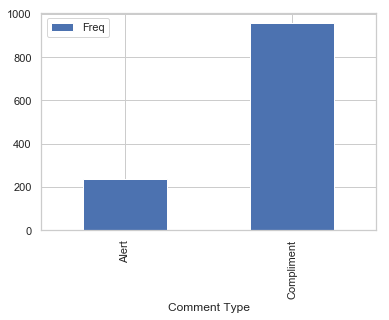

In [29]:
print('Task 2: use pandas and data viz libraries to explore & understand the columns and values in the text dataset')
print(documents.head())  #get first 5 observations in pandas dataframe
# Check data types for each variable
print(documents.info())
#assess data quailty - null values 
print(documents.isnull().sum())
#describe dataset values 
print(documents.describe())
#view histograp of categorical variables 
#summarize & plot pandas column using "groupby" function
summary = documents.groupby(['Comment Type'])["ID"].count().reset_index(name="count")
print(summary)
y = summary['count']
x = summary['Comment Type']   #iterate list to transfor dates for graphical use
data = pd.DataFrame({'Freq':y, 'Comment Type':x}).set_index(x) 
data.plot(kind='bar')
#plt.show()  #uncomment to show - otherwise holds execution until closed

In [30]:
print('CRISP-DM Task: Model Building')
print("Fitting LDA models with n_topic=%d, n_samples=%d and n_features=%d..." % (n_components, n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)  #scikit-learn library
lda.fit(bow)
print("\nTopics in LDA model:")
bow_feature_names = bow_vector.get_feature_names()

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, bow_feature_names, n_top_words) #note the improvement over last week's model!

CRISP-DM Task: Model Building
Fitting LDA models with n_topic=5, n_samples=2000 and n_features=1000...

Topics in LDA model:
Topic #0: drive inside window service customer light alley mentioned apology assuming
Topic #1: caught atms fraud needs area winamac eric west exceptional team
Topic #2: statements sent paper payment error letter canada wasn placed charged
Topic #3: fault funds send total deposited fee clicked able hold following
Topic #4: bank like know account service friendly just good don people



In [31]:
print('CRISP-DM Task: Model Evaluation ')
print('Step1 : get test topics then score them vs. current LDA model')
train, test = train_test_split(list(documents['Comment'].values), test_size = 0.2)
test_vector = bow_vector.fit_transform(test)
test_lda = lda.fit(test_vector)  #fit text vector within existing model - transpose to work
#Calculate approximate log-likelihood as score.
print(test_lda.score(test_vector)) #not meaningful in itself - compare vs. re-run models (closer to 0, the better)

CRISP-DM Task: Model Evaluation
Step1 : get test topics then score them vs. current LDA model
-21561.246461574996


In [32]:
print('Step 2: Use formal model evaluation stats, such as "perplexity" from scikit-learn library') 
# create test/train text documents to evaluate model 
vectoriser = CountVectorizer(stop_words = 'english', max_features=500)  #max features must be less that "n_features" variable!
doc_train = vectoriser.fit_transform(train)
features = vectoriser.get_feature_names()
doc_test = vectoriser.fit_transform(test)
news_lda = lda.fit(doc_train)
print(news_lda.perplexity(doc_test)) # lower the perplexity, the better

Step 2: Use formal model evaluation stats "perplexity"
2502.735504332799


In [33]:
print('Task 3: Compare LDA Model vs. Gensim word2vec td-idf model (last class)')
#class exercise - what is the difference? 

print('CRISP-DM Task: Model Deployment')
#gensim contains ablility to save and update models with future iterations
#lecture is TBD

Task 3: Compare vs. Gensim word2vec topic output
CRISP-DM Task: Model Deployment
